# Load Data

### In this notebook I'm going to be focusing on a trading card game that was popular when I was growing up called Magic The Gathering. I believe that the game provides an interesting categorization challenge. In the game cards are divided into five different colors (not counting colorless cards and cards with color combinations). Each of these colors signifies a certain ideological faction, and defines the flavor of that color's play style. 
### I'll start by taking a look at the token frequencies of each color in hopes of gaining some insight into what defines them. Then I'm going to see how well I can train a model to accurately categorize a card's color based only on its name. 

In [1]:
import pandas as pd

# read dataframe
cards_df = pd.read_pickle('mtg_data/cards_df.pickle')

# filter out non mono colored cards and shuffle dataframe
cards_df = cards_df[cards_df['encoding']!=5]
cards_df = cards_df.sample(frac=1).reset_index(drop=True)
cards_df.loc[0, :]

colorIdentity                                                      [B]
convertedManaCost                                                  1.0
name                                              Illness in the Ranks
originalText                                Creature tokens get -1/-1.
types                                                    [Enchantment]
ja_name                                                           集団疾病
ja_text                                      クリーチャー・トークンは－１/－１の修整を受ける。
ja_type                                                         エンチャント
ja_flavorText        「セレズニアは我々への付け届けを拒絶しました。それがいかに間違ったことか知らしめましょう。」...
encoding                                                             2
en_toks                                                [illness, rank]
ja_toks                                                       [集団, 疾病]
Name: 0, dtype: object

***

# Capturing the Essence of Each Color

### The first thing I want to do is see if I can capture the essence of each color by looking at their token frequencies

In [2]:
from collections import Counter, defaultdict

word_freqs = defaultdict(list)
color_symbol = {0: 'White', 1: 'Blue', 2: 'Black', 3: 'Red', 4: 'Green'}

for i in range(5):
    card_names = cards_df[cards_df['encoding']==i]['en_toks'].tolist()
    flattened = [t for tokens in card_names for t in tokens]
    freqs = Counter(flattened).most_common(20)
    word_freqs[color_symbol[i]] = [tup[0] for tup in freqs]

In [3]:
from tabulate import tabulate
print(tabulate(word_freqs, headers='keys', tablefmt='rst'))

========  =========  =========  =========  =========
White     Blue       Black      Red        Green
========  =========  =========  =========  =========
angel     drake      vampire    goblin     wurm
griffin   sphinx     blood      fire       druid
knight    merfolk    death      dragon     spider
aven      aether     dead       flame      nature
guardian  serpent    dark       lightning  wolf
light     jace       ghoul      ogre       dryad
spirit    aven       phyrexian  rage       elemental
kor       elemental  demon      giant      growth
sliver    dream      cabal      war        wild
guard     mage       shade      elemental  vine
shield    thought    plague     fury       hunt
paladin   wind       witch      burn       strength
serra     mind       rat        minotaur   primal
soul      faerie     grave      viashino   elvish
angelic   psychic    night      shaman     krosan
dawn      mystic     soul       storm      elf
gideon    cephalid   zombie     mage       centaur
capt

### This table lists words that give us some insight into each color. 
### For starters, you can see which creatures are most characterstic of each color. Angels for White, Drakes for Blue, Vampires for Black, Goblins for Red, and Wurms for Green. If someone familiar with mtg were asked to give a representative creature for each color, I could totally see them naming each of these (with the exception of maybe Drakes for Blue)
### There are also a variety of creature classes associated with each color. Paladins for White, Shamans for Red, etc.
### But maybe what captures each color's essence the most are the non creature type/class related words. Word's like fury and rage for Red, and growth and wild for Green.  

### Since tokens are unique across colors, I want to see if a model can learn to distinguish card colors given each card's name alone. There are definitely tokens that appear in more than one color though; the word elemental for example shows up in Blue, Red, and Green. But let's see how a model performs

***

# BOW Feature Extraction

### To start, I want to see if it'll be enough to use a BOW model and not worry about word order. So I'll start by creating a Count Vectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

en_tokens = cards_df['en_toks'].values
y = cards_df['encoding'].values

# disable analyzer since I'm applying CountVectorizer to list of lemms
vectorizer = CountVectorizer(analyzer=lambda x: x)

# K-Fold Cross Validation

### To choose the statistical model with the highest accuracy I'll use ten fold cross validation

In [5]:
# classification models
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

models = [SVC(), MultinomialNB(), RandomForestClassifier()]

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def get_score(model, vectorizer):
    clf = Pipeline([('vect', vectorizer), ('model', model)])
    return cross_val_score(clf, en_tokens, y, cv=10) # ndarray

for model in models:
    scores = get_score(model, vectorizer)
    print(f'{model}: {scores.mean()}')

SVC(): 0.5691806331471135
MultinomialNB(): 0.5875232774674116
RandomForestClassifier(): 0.5430167597765363


### Naive Bayes performs the best, so that's the model I'll go with. I'll use a tenth of the data to create a test set and then use the rest to train a naive bayes model

In [7]:
from sklearn.model_selection import train_test_split

tokens_train, tokens_test, y_train, y_test = train_test_split(en_tokens, y, test_size = 0.10)

# fit_tranform is used for iterable of strings, it combines the fit and transform steps
X_train = vectorizer.fit_transform(tokens_train)
X_test = vectorizer.transform(tokens_test)

print(X_train.shape)
print(X_test.shape)

(9666, 7606)
(1074, 7606)


In [8]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6061452513966481

### 60% isn't great, but it's still three times better than a 20% random guess. I also tried implementing a simple fully connected neural network but the accuracy wasn't that far off from the NB model. Since NB is less code I'll just stick with it for this notebook. 

### Let's take a look at where the model's going wrong using a confusion matrix

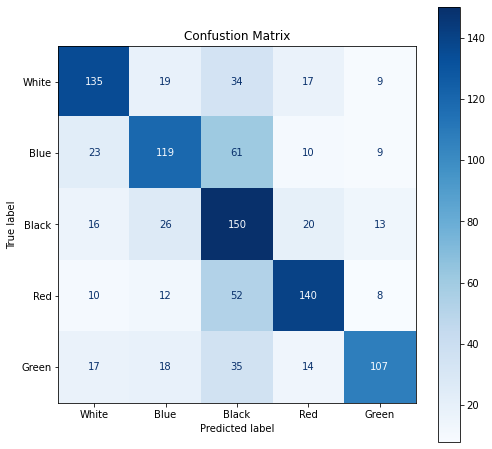

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['White', 'Blue', 'Black', 'Red', 'Green'],
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title('Confustion Matrix')
plt.show()

### It looks like the model is miscategorizing cards as Black the most, no matter which color they actually are. I want to take a look at some examples though and see if I can blame the model for some of these miscategorizations

In [12]:
y_pred = clf.predict(X_test)
false_blacks = defaultdict(list)

for x, y, p in zip(tokens_test, y_test, y_pred):
    if color_symbol[y] != 'Black' and color_symbol[p] == 'Black':
        false_blacks['card_name'] += [' '.join(x)]
        false_blacks['actual'] += [color_symbol[y]]
        false_blacks['predicted'] += [color_symbol[p]]
    if len(false_blacks['card_name']) >= 10:
        break

print(tabulate(false_blacks, headers='keys', tablefmt='fancy_grid'))

╒═════════════════╤══════════╤═════════════╕
│ card_name       │ actual   │ predicted   │
╞═════════════════╪══════════╪═════════════╡
│ rile            │ Red      │ Black       │
├─────────────────┼──────────┼─────────────┤
│ shunt           │ Red      │ Black       │
├─────────────────┼──────────┼─────────────┤
│ expose evil     │ White    │ Black       │
├─────────────────┼──────────┼─────────────┤
│ batterhorn      │ Red      │ Black       │
├─────────────────┼──────────┼─────────────┤
│ horrid swarm    │ Green    │ Black       │
├─────────────────┼──────────┼─────────────┤
│ strafe          │ Red      │ Black       │
├─────────────────┼──────────┼─────────────┤
│ pyroconvergence │ Red      │ Black       │
├─────────────────┼──────────┼─────────────┤
│ remand          │ Blue     │ Black       │
├─────────────────┼──────────┼─────────────┤
│ spitebellow     │ Red      │ Black       │
├─────────────────┼──────────┼─────────────┤
│ demoralize      │ Red      │ Black       │
╘═════════

### For cards like horrid swarm and Expose Evil I can't really blame the model. It's probably guessing Black based on the words "horrid" and "evil". This goes to show the importants of word order and semantics in language. A Count Vectorizer alone can't capture that information.

### I might be able to capure this information using a convolutional neural network though, and that's what I'm going to try to do next

***

# Integer Map Feature Extraction

### This time instead of a count vectorizer I'll create integer map vectors using keras' preprocessing library. These vectors will be converted to word embeddings later in the Convnet

In [104]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=7500) # keep 7500 most common
tokenizer.fit_on_texts(tokens_train)

X_train = tokenizer.texts_to_sequences(tokens_train)
X_test = tokenizer.texts_to_sequences(tokens_test)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

maxlen = 8 # this cuts sequences that exceed 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print('word tokens:', tokens_train[2])
print('padded vectors:', X_train[2])

word tokens: ['kavu', 'runner']
padded vectors: [ 36 187   0   0   0   0   0   0]


# Convolutional Neural Network

In [105]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [110]:
# create simple CNN

class CNN_NLP(nn.Module):
    """A 1D Convolutional Neural Network"""
    def __init__(self, 
                 embed_dim=512,
                 vocab_size=None,
                 filter_sizes=[2, 3, 4],
                 num_filters=[10, 10, 10],
                 num_classes=5,
                 dropout=0.5):

        """
        The constructor for CNN_NLP class.

        Args:
            embed_dim (int): Dimension of word vectors.
            filter_sizes (List[int]): List of filter sizes.
            num_filters (List[int]): Number of filters for each filter size.
            num_classes (int): Number of classes.
            dropout (float): Dropout rate.
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                        embedding_dim=self.embed_dim,
                                        padding_idx=0,
                                        max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        # Get embeddings from input_ids
        # Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute x_embed to match input shape requirement of nn.Conv1d
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list], dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [111]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# convert train and test sets to tensors
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

# hyperparameters
num_epochs = 10
num_classes = 5
batch_size = 128
learning_rate = 0.001
vocab_size = vocab_size

# load data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [112]:
# initialize network

cnn_model = CNN_NLP(vocab_size=vocab_size, num_classes=num_classes).to(device)

# loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

# train network

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        logits = cnn_model(data)
        loss = criterion(logits, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

In [113]:
# check accuracy on training & test to see how our model performs

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval() # evaluation mode

    # don't have to compute gradient when checking the accuracy
    with torch.no_grad(): 
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            logits = cnn_model(x)
            _, predictions = logits.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    model.train() # return model to train

check_accuracy(train_loader, cnn_model)
check_accuracy(test_loader, cnn_model)

Got 9528 / 9666 with accuracy 98.57
Got 657 / 1074 with accuracy 61.17


### The Convnet performs about as well the the BOW naive bayes classifier. Convnets are designed to be able to capture semantic relationships and context, but the names of magic cards are short, so it might be difficult to find any contextual information that will help. 